In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json
import shutil
import healpy

from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess

%matplotlib inline

In [3]:
initial_mtl_file = "targets/subset_dr8_mtl_dark_gray_NGC.fits"
targets = Table.read(initial_mtl_file)

In [4]:
pixweight_file = "/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits"
pixweight, header = fits.getdata(pixweight_file, 'PIXWEIGHTS', header=True)
hpxnside = header['HPXNSIDE']

In [5]:
Table(pixweight)

HPXPIXEL,FRACAREA,STARDENS,EBV,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,ELG,LRG,QSO,BGS_ANY,MWS_ANY,ALL,STD_FAINT,STD_BRIGHT,LRG_1PASS,LRG_2PASS,BGS_FAINT,BGS_BRIGHT,BGS_WISE,MWS_BROAD,MWS_MAIN_RED,MWS_MAIN_BLUE,MWS_WD,MWS_NEARBY
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,0.980634,457.528,0.0892718,2780.19,2013.2,298.442,1669.17,1032.87,138.744,2.58075,0.682658,1.35885,1.10376,1.02002,2287.64,705.355,419.4,1334.46,915.055,5528.46,57.1909,19.0637,400.337,305.018,552.846,781.61,0.0,495.655,95.3182,324.082,0.0,0.0
1,0.999698,495.655,0.10813,2841.96,2065.16,301.767,1717.01,1058.98,139.818,2.61975,0.679457,1.3676,1.10575,1.0115,2459.21,629.1,305.018,1124.76,972.246,5242.5,57.1909,0.0,381.273,247.827,381.273,705.355,38.1273,419.4,114.382,438.464,0.0,0.0
2,0.998935,324.082,0.0835982,2844.06,2103.71,275.169,1672.75,1069.77,133.88,2.57428,0.676512,1.31849,1.11161,1.07002,2421.08,419.4,209.7,2992.99,934.119,6767.6,95.3182,57.1909,209.7,209.7,895.992,2077.94,19.0637,381.273,95.3182,457.528,0.0,0.0
3,1.03249,305.018,0.0903878,2677.02,2040.33,265.27,1526.29,1064.84,127.024,2.57899,0.679367,1.34237,1.12885,1.06931,2459.21,552.846,228.764,1315.39,934.119,5375.95,38.1273,19.0637,381.273,171.573,571.909,705.355,38.1273,457.528,133.446,343.146,0.0,0.0
4,1.01342,590.973,0.106728,2472.99,1645.86,251.791,1581.52,852.609,116.365,2.57793,0.662332,1.43958,1.1395,1.01186,2192.32,781.61,152.509,1048.5,972.246,5013.74,57.1909,0.0,533.782,247.827,381.273,667.228,0.0,590.973,57.1909,324.082,0.0,19.0637
5,0.996648,514.719,0.0939747,1766.92,939.107,153.506,1217.75,517.151,69.7392,2.4718,0.63304,1.59763,1.21069,1.00315,2535.47,705.355,324.082,1048.5,819.737,5166.25,19.0637,38.1273,590.973,114.382,533.782,457.528,57.1909,362.209,152.509,305.018,0.0,0.0
6,0.998935,362.209,0.0946961,2892.07,1884.51,282.814,1714.08,1007.95,135.987,2.62698,0.681031,1.36397,1.17601,1.05707,2649.85,476.591,438.464,1220.07,1010.37,5547.52,57.1909,38.1273,266.891,209.7,476.591,648.164,95.3182,514.719,95.3182,400.337,0.0,0.0
7,1.02562,285.955,0.092858,3026.93,1582.52,273.611,1752.53,879.815,128.345,2.49147,0.640421,1.36608,1.23789,1.05517,2554.53,610.037,247.827,1162.88,762.546,5223.44,76.2546,38.1273,552.846,57.1909,362.209,800.673,0.0,362.209,190.636,209.7,0.0,0.0
8,1.02867,552.846,0.0812066,2454.4,1723.12,226.535,1451.63,897.152,111.306,2.57366,0.681933,1.34294,1.12922,1.08971,2211.38,266.891,285.955,1753.86,953.182,5375.95,0.0,0.0,228.764,38.1273,552.846,1201.01,0.0,457.528,171.573,305.018,19.0637,38.1273


In [6]:
pixelarea = healpy.pixelfunc.nside2pixarea(hpxnside, degrees=True)
print(pixelarea)

0.0524558528257


In [7]:
theta_w, phi_w = healpy.pix2ang(hpxnside, pixweight['HPXPIXEL'], nest=True)

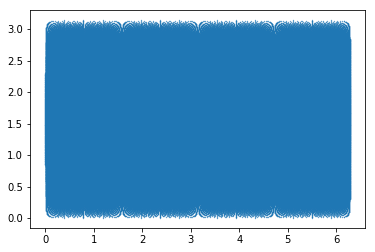

In [27]:
plt.scatter(phi_w, theta_w, s=0.1)

In [17]:
hpxnside_sample = 64
npix_sample = healpy.nside2npix(hpxnside_sample)
print(npix_sample)
pixnumber_sample = healpy.ang2pix(hpxnside_sample, theta_w, phi_w, nest=True)

subpixels = {}
for i in range(npix_sample):
    ii_sample = pixnumber_sample==i
    subpixels[i] =  healpy.ang2pix(hpxnside, theta_w[ii_sample], phi_w[ii_sample], nest=True)

49152


In [10]:
covered_area = np.ones(npix_sample)
for i in range(npix_sample):
    sum_weight = np.sum(pixweight['FRACAREA'][subpixels[i]])
    if sum_weight>0.0:
        covered_area[i] = np.sum(pixweight['FRACAREA'][subpixels[i]]**2)/np.sum(pixweight['FRACAREA'][subpixels[i]])
    else:
        covered_area[i] = 0.0

In [18]:
theta_s, phi_s = healpy.pix2ang(hpxnside_sample, np.arange(npix_sample), nest=True)

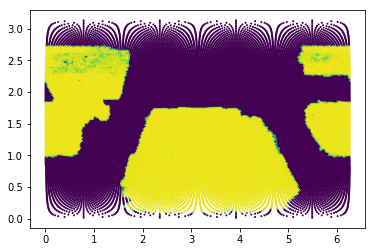

In [19]:
plt.scatter(phi_s, theta_s, c=covered_area, s=1.0)

In [50]:
pixelarea_sample = healpy.pixelfunc.nside2pixarea(hpxnside_sample, degrees=True)
n_lya_qso_in_pixel = np.int_(covered_area * 50 * pixelarea_sample)
print(np.sum(n_lya_qso_in_pixel))

975988


In [21]:
targets_phi = np.deg2rad(targets['RA'])
targets_theta = np.deg2rad(90.0-targets['DEC'])

In [22]:
r = np.random.random(len(targets_phi))
rr = r <0.001

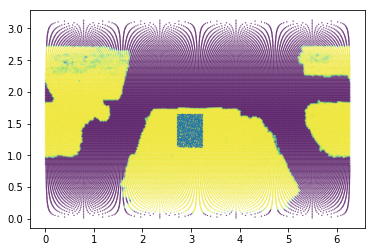

In [38]:
plt.scatter(phi_s, theta_s, c=covered_area, s=0.1)
plt.scatter(targets_phi[rr], targets_theta[rr], s=0.01)

In [39]:
pixnumber_targets = healpy.ang2pix(hpxnside_sample, targets_theta, targets_phi, nest=True)

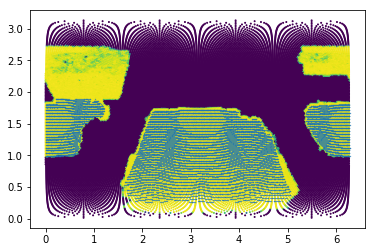

In [40]:
tiles = desimodel.io.load_tiles()
plt.scatter(phi_s, theta_s, c=covered_area, s=1.0)
plt.scatter(np.deg2rad(tiles['RA']), np.deg2rad(90-tiles['DEC']), s=0.1)

In [43]:
is_qso = (targets['DESI_TARGET'] & desi_mask.QSO)!=0
print(np.count_nonzero(is_qso))
print(np.sum(n_lya_qso_in_pixel[list(set(pixnumber_targets))]))

246913
48004.3351016


In [44]:
pixnumber_target_list = list(set(pixnumber_targets))

In [46]:
n_qso_per_pixel_targets = np.ones(len(pixnumber_target_list))
for i in range(len(pixnumber_target_list)):
    ii_targets = is_qso & (pixnumber_targets==pixnumber_target_list[i])
    n_qso_per_pixel_targets[i] = np.count_nonzero(ii_targets)

In [55]:
n_lya_desired_pixel_targets = np.random.poisson(n_lya_qso_in_pixel[pixnumber_target_list])

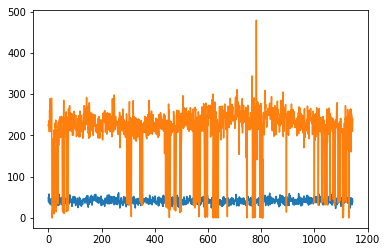

In [56]:
plt.plot(n_lya_desired_pixel_targets)
plt.plot(n_qso_per_pixel_targets)

In [67]:
is_lya_qso = np.repeat(False, len(targets))
n_targets = len(targets)
target_ids = np.arange(n_targets)

for i in range(len(pixnumber_target_list)):
    ii_targets = is_qso & (pixnumber_targets==pixnumber_target_list[i])
    n_qso_in_pixel = np.count_nonzero(ii_targets)
    n_lya_desired = np.random.poisson(n_qso_in_pixel)
    if n_lya_desired >= n_qso_in_pixel:
        is_lya_qso[ii_targets] = True
    else:
        print(len(target_ids[ii_targets]), n_lya_desired)
        ii_lya_qso = np.random.choice(target_ids[ii_targets], n_lya_desired, replace=False)
        is_lya_qso[ii_lya_qso] = True
    

225 221
261 236
217 215
289 286
233 228
209 193
290 287
249 232
11 8
171 158
213 207
218 214
237 229
198 195
169 148
217 207
232 231
239 232
194 183
245 235
229 193
230 222
185 161
16 12
14 10
182 164
11 7
192 172
195 187
227 210
226 213
257 228
21 15
244 233
17 16
176 160
212 196
235 221
227 213
254 252
210 181
242 217
231 223
235 234
200 176
230 223
258 250
223 204
220 217
221 211
213 205
248 231
196 189
259 256
244 230
235 232
248 236
230 205
223 212
193 183
227 224
251 233
218 206
268 257
213 200
263 255
292 273
226 220
270 252
193 163
256 248
228 217
231 223
218 201
250 244
211 207
223 204
227 221
250 219
239 230
214 197
211 206
222 214
194 168
246 245
222 221
232 215
236 217
210 196
212 206
213 206
234 194
208 200
259 222
231 222
208 193
248 237
203 194
222 221
214 196
248 227
253 235
241 220
217 208
223 205
244 237
197 187
223 221
209 198
237 223
298 294
251 242
214 206
237 232
246 234
232 223
224 210
233 208
216 206
208 191
202 186
241 236
216 210
200 194
247 222
235 211
213 20

In [68]:
print(np.count_nonzero(is_lya_qso))

240662


In [59]:
is_lya_qso = np.repeat(False, len(targets))


In [60]:
is_lya_qso

array([False, False, False, ..., False, False, False], dtype=bool)